In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\sansk\AppData\Local\Temp\ipykernel_13992\2269961727.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
print(os.listdir('./data'))

['FAKE', 'REAL']


In [3]:
img = cv2.imread(os.path.join('./data/FAKE/1000 (2).jpg'))
img.shape

(32, 32, 3)

In [4]:
path = './data'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path, image_size=(32, 32), batch_size=32)

Found 100000 files belonging to 2 classes.


In [5]:
dataset = dataset.map(lambda x, y : (x/255, y))

In [6]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset, 3127, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000)

In [8]:
len(train_ds)

2188

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [10]:
model = Sequential()

model.add(Conv2D(16, (4, 4), 1, activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (4, 4), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (4, 4), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 16)        784       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 16)          8208      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 16)          

In [12]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train_ds, epochs=5, validation_data=val_ds , callbacks=[tensorboard_callback])

Epoch 1/5


2188/2188 [==============================] - 759s 177ms/step - loss: 0.4348 - accuracy: 0.7972 - val_loss: 0.3705 - val_accuracy: 0.8368
Epoch 2/5
2188/2188 [==============================] - 729s 178ms/step - loss: 0.3314 - accuracy: 0.8596 - val_loss: 0.3650 - val_accuracy: 0.8457
Epoch 3/5
2188/2188 [==============================] - 734s 170ms/step - loss: 0.2818 - accuracy: 0.8830 - val_loss: 0.2442 - val_accuracy: 0.9004
Epoch 4/5
2188/2188 [==============================] - 507s 73ms/step - loss: 0.2555 - accuracy: 0.8945 - val_loss: 0.2355 - val_accuracy: 0.9045
Epoch 5/5
2188/2188 [==============================] - 74s 22ms/step - loss: 0.2378 - accuracy: 0.9027 - val_loss: 0.2237 - val_accuracy: 0.9111


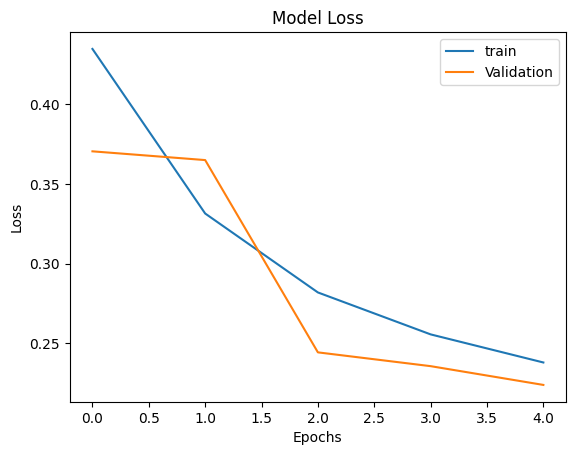

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'Validation'])
plt.show()

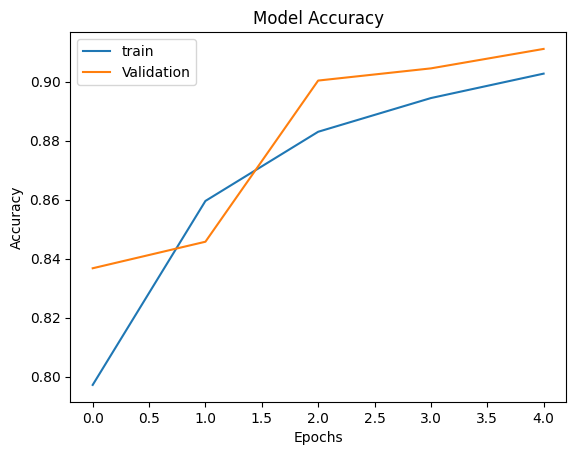

In [14]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'Validation'])
plt.show()

In [15]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

In [16]:
len(test_ds)

468

In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test_ds.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 26ms/step


In [23]:
print(f'Precision: {pre.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.8957797288894653, Recall: 0.9309976100921631, Accuracy: 0.9114583134651184


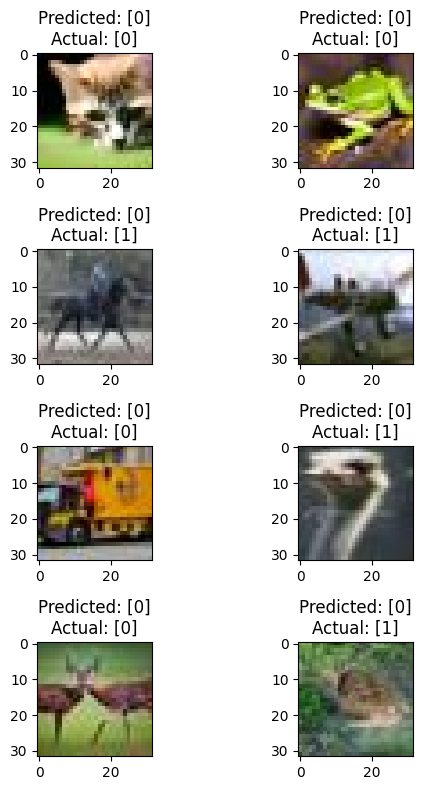

In [41]:
count=0
y_classes = [np.argmax(Y, axis=None, out=None) for Y in y]
fig,ax=plt.subplots(4,2)
fig.set_size_inches(8,8)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X[count])
        ax[i,j].set_title("Predicted: "+str(([y_classes[count]]))+"\n"
                          +"Actual: "+str((([y[count]]))))
        plt.tight_layout()
        count+=1